In [1]:
import re
import random
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tempfile
import matplotlib.pyplot as plt
from functools import partial
from tensorflow.keras.applications import imagenet_utils,ResNet50,VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,concatenate
from tensorflow.keras.utils import plot_model

from tensorflow.keras import backend as K

import cv2
print(cv2.__version__)
print(tf.__version__)

4.5.1
2.4.0


In [2]:
base_dir = 'H:\ISIC Data\jpeg\\'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with training benign pictures
train_benign_dir = os.path.join(train_dir, 'benign')

# Directory with training malignant pictures
train_mal_dir = os.path.join(train_dir, 'malig')

# Directory with validation benign pictures
validation_benign_dir = os.path.join(validation_dir, 'benign')

# Directory with validation malignant pictures
validation_mal_dir = os.path.join(validation_dir, 'malig')

print(train_benign_dir)
print(train_mal_dir)
print(validation_benign_dir)
print(validation_mal_dir)

H:\ISIC Data\jpeg\train\benign
H:\ISIC Data\jpeg\train\malig
H:\ISIC Data\jpeg\val\benign
H:\ISIC Data\jpeg\val\malig


In [3]:
benign_tr = os.listdir(train_benign_dir)
mal_tr = os.listdir(train_mal_dir)

benign_val = os.listdir(validation_benign_dir)
mal_val = os.listdir(validation_mal_dir)

benign_tr = [os.path.join(train_benign_dir, x) for x in benign_tr]
mal_tr = [os.path.join(train_mal_dir, x) for x in mal_tr]
benign_val = [os.path.join(validation_benign_dir, x) for x in benign_val]
mal_val = [os.path.join(validation_mal_dir, x) for x in mal_val]

total_train = benign_tr + mal_tr
total_val = benign_val + mal_val

In [4]:
total_val[0]

'H:\\ISIC Data\\jpeg\\val\\benign\\ISIC_2793142.jpg'

In [2]:
def data_to_array(total):
    random.shuffle(total)
    X = np.zeros(shape=(len(total),224,224,3), dtype=np.uint8)
    y = []
    for i in range(len(total)):
        img = cv2.imread(total[i])
        img = cv2.resize(img, (224, 224))
        X[i] = img
        if len(re.findall('benign', total[i])) == 1:
            y.append(0)
        else:
            y.append(1)
    y = np.array(y)
    return X, y

In [22]:
X_train, y_train = data_to_array(total_train)
X_test, y_test = data_to_array(total_val)

In [23]:
print(len(X_train) , X_train.shape )
print(len(y_train) , y_train.shape )
print(len(X_test) , X_test.shape )
print(len(y_test) , y_test.shape )

27026 (27026, 224, 224, 3)
27026 (27026,)
6100 (6100, 224, 224, 3)
6100 (6100,)


In [8]:
#y_train = np.concatenate((y_train, [1]))
#y_test = np.concatenate((y_test, [1]))

In [3]:
def create_model(base_model):
    base_model.trainable = False
    global_average_layer = GlobalAveragePooling2D()(base_model.output)
    prediction_layer = Dense(1, activation='sigmoid')(global_average_layer)
    model = Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    return model

In [4]:
#model_loading stuff
class FixedDropout(tf.keras.layers.Dropout):
    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]
        return tuple(noise_shape)
def load_all_models():
    all_models = []
    model_names = ['vgg_model.h5', 'resnet_model.h5', 'eff_model.h5']
    for model_name in model_names:
        filename = os.path.join('H:/ISIC Data/notebooks/models/', model_name)
        model = tf.keras.models.load_model(filename,custom_objects={'FixedDropout':FixedDropout})
        all_models.append(model)
        print('loaded:', filename)
    return all_models

In [7]:
# define stacked model from multiple member input models

def define_stacked_model(models,output_bias = None):
    for i,model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(1, activation='sigmoid',bias_initializer=output_bias)(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=tf.keras.metrics.AUC(name='auc'))
    return model

In [8]:
#load the model ensemble
models = load_all_models()
model = define_stacked_model(models)

loaded: H:/ISIC Data/notebooks/models/vgg_model.h5
loaded: H:/ISIC Data/notebooks/models/resnet_model.h5
loaded: H:/ISIC Data/notebooks/models/eff_model.h5


In [24]:
#create input lists as we have to input to multiple input heads for multiple models
X = [X_train for _ in range(len(model.input))]
X_1 = [X_test for _ in range(len(model.input))]

In [25]:
# fit stacked model on test dataset
BATCH_SIZE = 64
stacked_model_history = model.fit(X, y_train,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(total_train) // BATCH_SIZE,
                    epochs=5,
                    validation_data=(X_1, y_test))

Epoch 1/5
422/422 [==============================] - 4090s 10s/step - loss: 0.4948 - auc: 0.5010 - val_loss: 0.1586 - val_auc: 0.4751
Epoch 2/5
422/422 [==============================] - 4069s 10s/step - loss: 0.1310 - auc: 0.4939 - val_loss: 0.0915 - val_auc: 0.4828
Epoch 3/5
422/422 [==============================] - 4085s 10s/step - loss: 0.0911 - auc: 0.4823 - val_loss: 0.0850 - val_auc: 0.4895
Epoch 4/5
422/422 [==============================] - 4043s 10s/step - loss: 0.0924 - auc: 0.4915 - val_loss: 0.0841 - val_auc: 0.4908
Epoch 5/5
422/422 [==============================] - 4042s 10s/step - loss: 0.0920 - auc: 0.4962 - val_loss: 0.0838 - val_auc: 0.5001


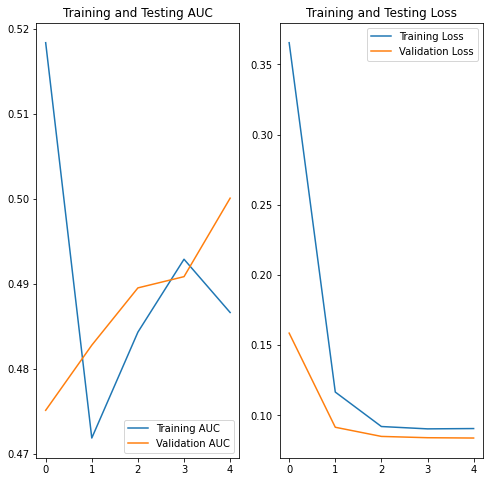

In [26]:
auc = stacked_model_history.history['auc']
val_auc = stacked_model_history.history['val_auc']

loss = stacked_model_history.history['loss']
val_loss = stacked_model_history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Testing AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()